# PairwiseAttentionRegresssor Tutorial

This notebook is a tutorial for PairwiseAttentionRegressor.

In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor

import sys
sys.path.append('..')
from mlprotobox.attention_stacking import PairwiseAttentionRegressor

In [2]:
SEED = 42
np.random.seed(SEED)

## What is PairwiseAttentionRegressor?

PairwiseAttentionRegressor is a model which predicts target with weighted mean of features, like attention mechanism.

Now, let us consider a predictive problem where we have $D$ features $x_1, \cdots, x_D$ and a target $y$. Assume that each of $x_1, \cdots, x_D$ is a predictor for $y$, e.g. a weak learner in ensemble learning context. PairwiseAttentionRegressor predicts the target with the following formula:

$$
\hat{y} = \frac{1}{D(D-1)} \sum_{1\leq i,j\leq D, i\neq j} \left( x_j + model_{ij}(x) \times (x_i-x_j) \right)
$$

$model_{ij}(x)$ predicts the weight of $x_i$ when $x_i$ and $x_j$ are given, and it is trained with the following loss:

$$
\begin{matrix}
L &:=& \frac{1}{N} \sum_{1\leq i,j\leq D, i\neq j} \sum_{n=1}^N | y_n - x_{nj} - model_{ij}(x_n) \times (x_{ni}-x_{nj}) |^2 \\
&=& \frac{1}{N} \sum_{1\leq i,j\leq D, i\neq j} \sum_{n=1}^N (x_{ni}-x_{nj})^2 | \frac{y_n - x_{nj}}{x_{ni}-x_{nj}} - model_{ij}(x_n) |^2 \\
&=& \frac{1}{N} \sum_{1\leq i,j\leq D, i\neq j} \sum_{n=1}^N w_{nij} | \varepsilon_{nij} - model_{ij}(x_n) |^2\\
\end{matrix}
$$

where $\varepsilon_{nij} = \frac{y_n - x_{nj}}{x_{ni}-x_{nj}}$ are alternative targets and $w_{nij} = (x_{ni}-x_{nj})^2$ are sample weights for each alternative target.

## How to use PairwiseAttentionRegressor?

The most practical way to use this is to use it as a `final_estimator` in `StackingRegressor` or `StackingCVRegressor` in `sklearn.ensemble`.

But first, in order to see how PairwiseAttentionRegressor works, let us use it as a standalone model.

### Toy Example

Let us consider the following true model:

$$
y = \begin{cases}
x & \text{if } x\geq 1 \\
x^2 & \text{if } |x| < 1 \\
- floor(x) & \text{if } x < -1
\end{cases}
$$

In [3]:
# generate data
X = 2*np.random.randn(1000)[:, np.newaxis]
y = (
    (-np.floor(X) * (X <= -1))
    + X ** 2 * (np.abs(X) < 1)
    + X * (X >= 1)
).flatten()

In this model, $x$ and $y$ are distributed as follows:

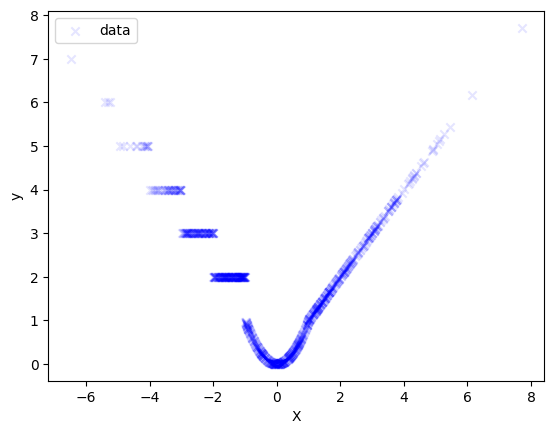

In [4]:
plt.scatter(X, y, alpha=0.1, marker='x', color='blue', label='data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In this case, $x$, $x^2$ and $-floor(x)$ are weak learners.
So, we can use PairwiseAttentionRegressor to predict $y$ with $x$, $x^2$ and $-floor(x)$.

Here, assume that we have already known $x$, $x^2$ and $-floor(x)$ are weak learners.

The following code create an instance of PairwiseAttentionRegressor and train it, where DecisionTreeRegressor is used as an attention model.

In [5]:
pipe = make_pipeline(
    FunctionTransformer(lambda x: np.hstack([x, x**2, -np.round(x)])),
    PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=3),
        attentioned_columns=[0, 1, 2],
    ),
)
pipe.fit(X, y)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x00000231EF83EDD0>)),
                ('pairwiseattentionregressor',
                 PairwiseAttentionRegressor(attentioned_columns=[0, 1, 2],
                                            base_estimator=DecisionTreeRegressor(max_depth=3)))])

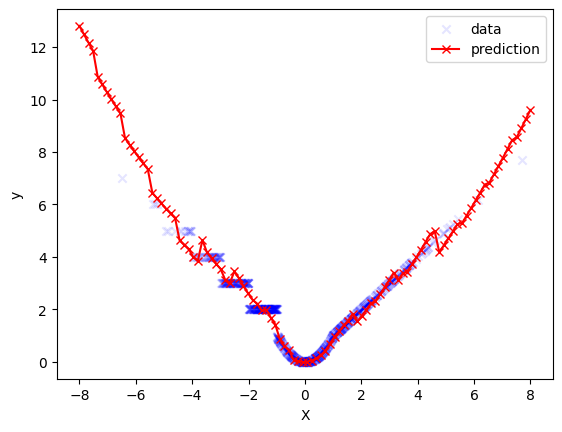

In [6]:
plt.scatter(X, y, alpha=0.1, marker='x', color='b', label='data')
plt.plot(np.linspace(-8, 8, 100), pipe.predict(np.linspace(-8, 8, 100)[:, np.newaxis]), 'rx-', label='prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

And if you want to see the weights of each weak learner, you can use `get_weights` method.

Note that, in this case, we can know the true weight, and the following graph shows that the predicted weight is far from the true weight, but PairwiseAttentionRegressor does not try to predict the true weight.

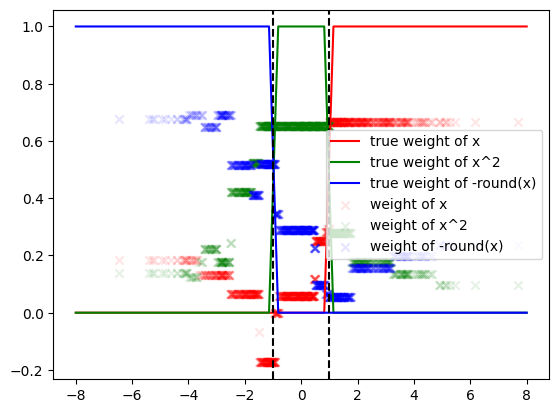

In [7]:
_weight = pipe[-1].get_weight(pipe[:-1].transform(X))
plt.plot(np.linspace(-8, 8), np.linspace(-8, 8) > 1, 'r-', label='true weight of x')
plt.plot(np.linspace(-8, 8), np.abs(np.linspace(-8, 8)) < 1, 'g-', label='true weight of x^2')
plt.plot(np.linspace(-8, 8), np.linspace(-8, 8) < -1, 'b-', label='true weight of -round(x)')
plt.scatter(X, _weight[:, 0], alpha=0.1, marker='x', color='r', label='weight of x')
plt.scatter(X, _weight[:, 1], alpha=0.1, marker='x', color='g', label='weight of x^2')
plt.scatter(X, _weight[:, 2], alpha=0.1, marker='x', color='b', label='weight of -round(x)')
plt.axvline(-1, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.legend()
plt.show()

### Practical Example

In this section, let us see the real-world example.

In [8]:
X, y = load_diabetes(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [9]:
# create various models

linear = LinearRegression()
tree = DecisionTreeRegressor(max_depth=7, random_state=SEED)
kneighbor = KNeighborsRegressor(n_neighbors=5)

first_layer = [
    ('linear', linear),
    ('tree', tree),
    ('kneighbors', kneighbor),
]

par = StackingRegressor(
    first_layer,
    final_estimator=PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=5),
        attentioned_columns=[0, 1, 2],
    ),
    cv=3,
)

par_with_clip = StackingRegressor(
    first_layer,
    final_estimator=PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=5),
        attentioned_columns=[0, 1, 2],
        clip_alternative_target=True,
        # Clip alternative targets $\varepsilon_{ij}$ in the range of [0, 1]
    ),
    cv=3,
)

par_with_clip_and_qtrans = StackingRegressor(
    first_layer,
    final_estimator=PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=5),
        attentioned_columns=[0, 1, 2],
        clip_alternative_target=True,
        # Clip alternative targets $\varepsilon_{ij}$ in the range of [0, 1]
        invertible_transformer=QuantileTransformer(random_state=SEED),
    ),
    cv=3,
)

par_passthrough = StackingRegressor(
    first_layer,
    final_estimator=PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=5),
        attentioned_columns=[0, 1, 2],
    ),
    cv=3,
    passthrough=True,
)

par_with_clip_passthrough = StackingRegressor(
    first_layer,
    final_estimator=PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=5),
        attentioned_columns=[0, 1, 2],
        clip_alternative_target=True,
        # Clip alternative targets $\varepsilon_{ij}$ in the range of [0, 1]
    ),
    cv=3,
    passthrough=True,
)

par_with_clip_and_qtrans_passthrough = StackingRegressor(
    first_layer,
    final_estimator=PairwiseAttentionRegressor(
        base_estimator=DecisionTreeRegressor(max_depth=5),
        attentioned_columns=[0, 1, 2],
        clip_alternative_target=True,
        # Clip alternative targets $\varepsilon_{ij}$ in the range of [0, 1]
        invertible_transformer=QuantileTransformer(random_state=SEED),
    ),
    cv=3,
    passthrough=True,
)

In [10]:
models = {
    "linear": linear,
    "tree": tree,
    "kneighbor": kneighbor,
    "par": par,
    "par_with_clip": par_with_clip,
    "par_with_clip_and_qtrans": par_with_clip_and_qtrans,
    "par_passthrough": par_passthrough,
    "par_with_clip_passthrough": par_with_clip_passthrough,
    "par_with_clip_and_qtrans_passthrough": par_with_clip_and_qtrans_passthrough,
}

In [11]:
for k, model in models.items():
    model.fit(Xtr, ytr)
    # score = float(r2_score(yte, model.predict(Xte)))
    score = float(np.sqrt(mean_squared_error(yte, model.predict(Xte))))
    # score = float(mean_absolute_error(yte, model.predict(Xte)))
    print(f'{k}: {score}')

linear: 53.853445836765914
tree: 65.46571233579961
kneighbor: 54.946114563433675
par: 60.07575695183759
par_with_clip: 51.605310195940014
par_with_clip_and_qtrans: 52.441835996423116
par_passthrough: 55.274030143365266
par_with_clip_passthrough: 53.2667299093868
par_with_clip_and_qtrans_passthrough: 52.69945720289493


d:\dev_libs\hmds-prototypes\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
d:\dev_libs\hmds-prototypes\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
d:\dev_libs\hmds-prototypes\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
d:\dev_libs\hmds-prototypes\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
d:\dev_libs\hmds-prototypes\.venv\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantile